<h1>Phase 4 Final Project Submission</h1>

<h3>Student Name: Jason Lombino</h3>
<hr>

<h1>Business Problem</h1>

<h1>Libraries</h1>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from skimage.segmentation import mark_boundaries
from lime import lime_image
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import metrics
from tensorflow.keras import preprocessing
from tensorflow.keras import callbacks
from tensorflow.keras import optimizers
from tensorflow.keras import applications
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

<h1>Data

In [2]:
# Data should be in three folders (train, test, and val)
train_path = 'chest_xray/train'
test_path = 'chest_xray/test'
val_path = 'chest_xray/val'

In [3]:
# Data generator with some preprocessing steps for training data
train_generator = preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=45,
    zoom_range=0.3
)

train_ds = train_generator.flow_from_directory(
    train_path,
    target_size=(256,256),
    class_mode='binary',
)

# Class sizes for pie chart
train_norm = len(os.listdir(train_path + '/NORMAL'))
train_sick = len(os.listdir(train_path + '/PNEUMONIA'))

Found 4175 images belonging to 2 classes.


In [4]:
# Data generator without proprocessing steps for validation data
val_generator = preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

# Shuffle is not needed for test and validation data
val_ds = val_generator.flow_from_directory(
    val_path,
    target_size=(256,256),
    class_mode='binary',
    shuffle=False
)

# Class sizes for pie chart
val_norm = len(os.listdir(val_path + '/NORMAL'))
val_sick = len(os.listdir(val_path + '/PNEUMONIA'))

Found 1057 images belonging to 2 classes.


In [5]:
# Data generator without preprocessing steps for test data
test_generator = preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

# Shuffle is not needed for test and validation data
test_ds = test_generator.flow_from_directory(
    test_path,
    target_size=(256,256),
    class_mode='binary',
    shuffle=False
)

# Class sizes for pie chart
test_norm = len(os.listdir(test_path + '/NORMAL'))
test_sick = len(os.listdir(test_path + '/PNEUMONIA'))

Found 624 images belonging to 2 classes.


<h1>Data Visualizations

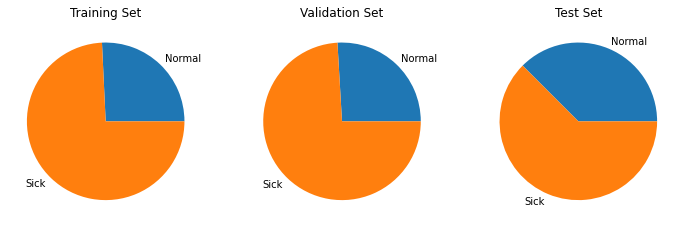

In [6]:
data_fig, data_ax = plt.subplots(1,3,figsize=(12,4))

# Training class sizes
data_ax[0].pie([train_norm,train_sick],labels=['Normal','Sick']);
data_ax[0].set_title('Training Set');

# Validation class sizes
data_ax[1].pie([val_norm,val_sick],labels=['Normal','Sick']);
data_ax[1].set_title('Validation Set');

# Test class sizes
data_ax[2].pie([test_norm,test_sick],labels=['Normal','Sick']);
data_ax[2].set_title('Test Set');

data_fig.set_facecolor('#FFFFFF')

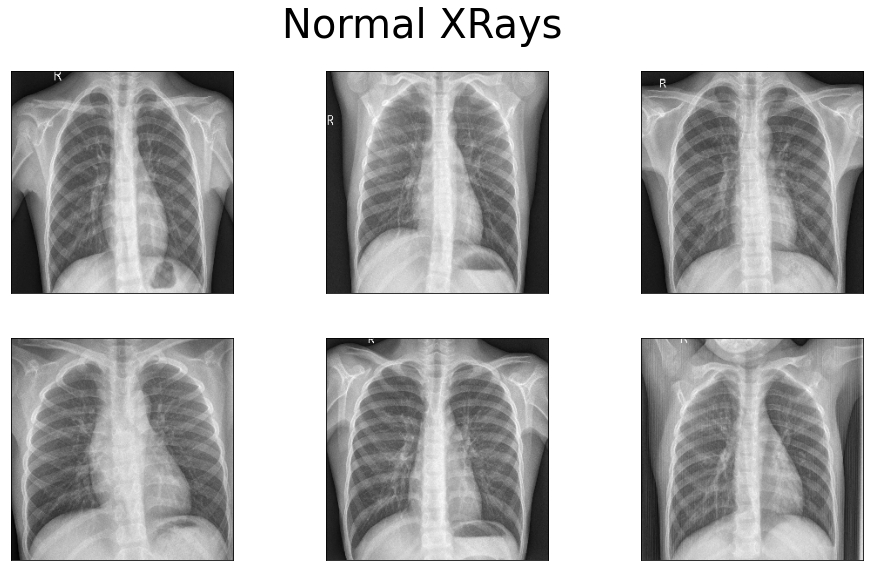

In [7]:
normal_images = []

# Pull 6 normal images from the test set
# Test set is ordered so normal images are at the beginning
for image in test_ds[0][0][:6]:
    normal_images.append(image)

normal_fig,normal_ax = plt.subplots(2,3,figsize=(16,9))

# Plot the 6 normal images pulled from the test set
for idx,image in enumerate(normal_images[:6]):
        active_axis = normal_ax[idx//3][idx%3]
        active_axis.imshow(image)
        active_axis.set_xticks([])
        active_axis.set_yticks([])
normal_fig.set_facecolor('#FFFFFF')
normal_fig.suptitle('Normal XRays', fontsize=40);

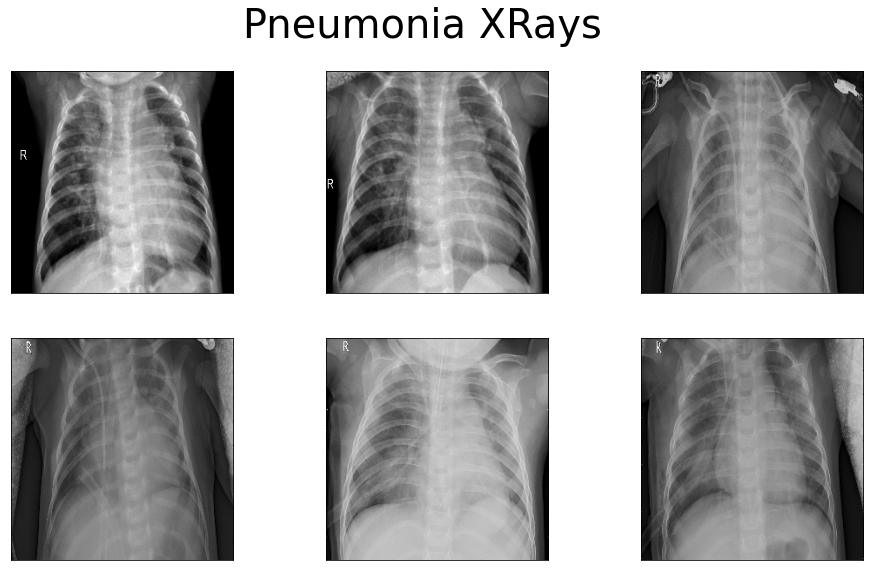

In [8]:
sick_images = []

# Pull 6 pneumonia images from the test set
# Test set is ordered so sick images are at the end
for image in test_ds[len(test_ds)-1][0][:6]:
    sick_images.append(image)

sick_fig,sick_ax = plt.subplots(2,3,figsize=(16,9))

# Plot the 6 pneumonia images pulled from the test set
for idx,image in enumerate(sick_images[:6]):
        active_axis = sick_ax[idx//3][idx%3]
        active_axis.imshow(image)
        active_axis.set_xticks([])
        active_axis.set_yticks([])
sick_fig.set_facecolor('#FFFFFF')
sick_fig.suptitle('Pneumonia XRays', fontsize=40);

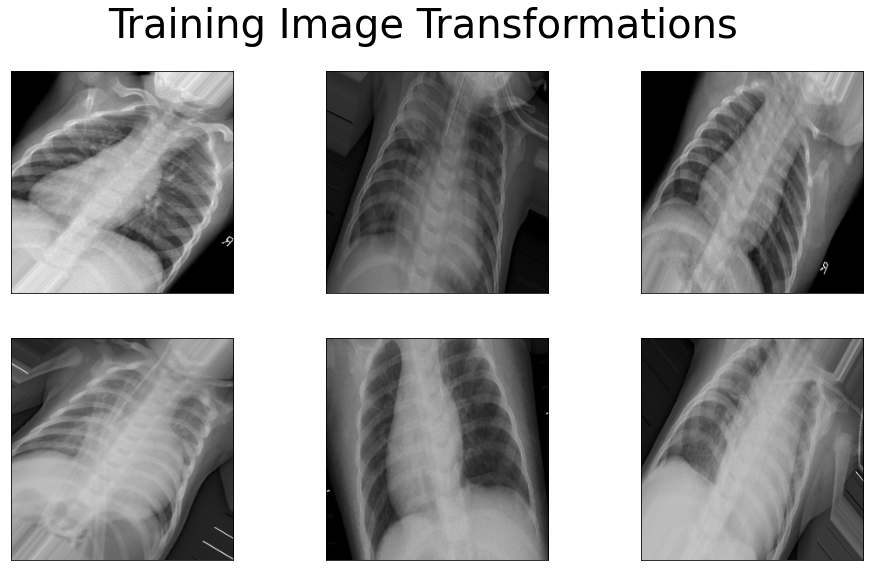

In [9]:
# Pull the first 6 images from the training set
train_prep = train_ds[0][0][:6]

train_fig,train_ax = plt.subplots(2,3,figsize=(16,9))

# Plot the 6 transformed images pulled from the training set
for idx,image in enumerate(train_prep[:6]):
        active_axis = train_ax[idx//3][idx%3]
        active_axis.imshow(image)
        active_axis.set_xticks([])
        active_axis.set_yticks([])
train_fig.set_facecolor('#FFFFFF')
train_fig.suptitle('Training Image Transformations', fontsize=40);

<h1>Modeling</h1>

Various models results

| Model Name                                     | % Train Accuracy | % Val Accuracy | 
|------------------------------------------------|------------------|----------------|
| * Basic CNN                                      | 98.8             | 96.7           | 
| Basic CNN Image Preprocessing                  | 93.5             | 91.2           | 
| Larger CNN                                     | 93.5             | 94.0           | 
| Larger CNN tanh Activation                     | 74.3             | 74.1           | 
| Larger CNN Dropout                             | 93.3             | 94.0           | 
| Larger CNN Larger Stride                       | 95.3             | 93.4           | 
| Larger CNN Double Convolutional Layers         | 95.5             | 94.0           | 
| Even Larger CNN                                | 94.8             | 94.5           | 
| Transfer Learning Xception                     | 96.6             | 94.0           | 
| Transfer Learning VGG16                        | 95.0             | 95.7           | 
| Transfer Learning VGG16 Decaying Learning Rate | 94.7             | 94.2           |

<h1>Second Best Model (Even Larger CNN)</h1>

In [10]:
nt_model = models.Sequential()

# First convolutional block
nt_model.add(layers.Conv2D(32, (1, 1), activation='relu',padding='same',
                        input_shape=(256, 256, 3)))     
nt_model.add(layers.Conv2D(32, (1, 1), activation='relu',padding='same'))                
nt_model.add(layers.MaxPooling2D((2, 2)))

# Second convolutional block
nt_model.add(layers.Conv2D(64, (1, 1), activation='relu',padding='same'))
nt_model.add(layers.Conv2D(64, (1, 1), activation='relu',padding='same'))
nt_model.add(layers.MaxPooling2D((2, 2)))

# Third convolutional block
nt_model.add(layers.Conv2D(128, (1, 1), activation='relu',padding='same'))
nt_model.add(layers.Conv2D(128, (1, 1), activation='relu',padding='same'))
nt_model.add(layers.MaxPooling2D((2, 2)))

# Fourth convolutional block
nt_model.add(layers.Conv2D(256, (1, 1), activation='relu',padding='same'))
nt_model.add(layers.Conv2D(256, (1, 1), activation='relu',padding='same'))
nt_model.add(layers.MaxPooling2D((2, 2)))

# Densely connected block with dropout
nt_model.add(layers.Flatten())
nt_model.add(layers.Dense(512, activation='relu'))
nt_model.add(layers.Dropout(rate=0.25))
nt_model.add(layers.Dense(512, activation='relu'))
nt_model.add(layers.Dropout(rate=0.25))
nt_model.add(layers.Dense(256, activation='relu'))
nt_model.add(layers.Dropout(rate=0.25))
nt_model.add(layers.Dense(128, activation='relu'))
nt_model.add(layers.Dropout(rate=0.25))
nt_model.add(layers.Dense(64, activation='relu'))
nt_model.add(layers.Dropout(rate=0.25))
nt_model.add(layers.Dense(32, activation='relu'))
nt_model.add(layers.Dense(1, activation='sigmoid'))

In [11]:
# Checkpoint the model after each epoch
nt_checkpoint = callbacks.ModelCheckpoint(
    monitor='val_loss',
    filepath='save_data/nt_model.hdf5',
    save_best_only=True,
    verbose=0
)

nt_callbacks = [nt_checkpoint]

# Metrics are Accuracy, Precision, and Recall
use_metrics = [metrics.BinaryAccuracy(),\
                metrics.Precision(),\
                metrics.Recall()]

In [12]:
# Compile the model with the Adam optimizer
nt_model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(),
    metrics=[use_metrics]
)

# Print overview of the model
print(nt_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      128       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      1056      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      2112      
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 64)      4160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                    

In [13]:
# Fit the model and save the results to history
with tf.device('/GPU:0'):
    nt_history = nt_model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=5,
        callbacks=nt_callbacks
    )

# Load the best model based on validation loss
nt_model.load_weights('save_data/nt_model.hdf5')

Epoch 1/5
131/131 [==============================] - 47s 313ms/step - loss: 0.5461 - binary_accuracy: 0.7382 - precision: 0.7424 - recall: 0.9913 - val_loss: 0.4984 - val_binary_accuracy: 0.7408 - val_precision: 0.7408 - val_recall: 1.0000
Epoch 2/5
131/131 [==============================] - 41s 311ms/step - loss: 0.3975 - binary_accuracy: 0.8091 - precision: 0.8327 - recall: 0.9297 - val_loss: 0.4263 - val_binary_accuracy: 0.7928 - val_precision: 0.7872 - val_recall: 0.9872
Epoch 3/5
131/131 [==============================] - 41s 314ms/step - loss: 0.3205 - binary_accuracy: 0.8642 - precision: 0.8927 - recall: 0.9287 - val_loss: 0.1873 - val_binary_accuracy: 0.9281 - val_precision: 0.9771 - val_recall: 0.9246
Epoch 4/5
131/131 [==============================] - 41s 314ms/step - loss: 0.2439 - binary_accuracy: 0.9063 - precision: 0.9329 - recall: 0.9416 - val_loss: 0.1825 - val_binary_accuracy: 0.9290 - val_precision: 0.9863 - val_recall: 0.9170
Epoch 5/5
131/131 [=====================

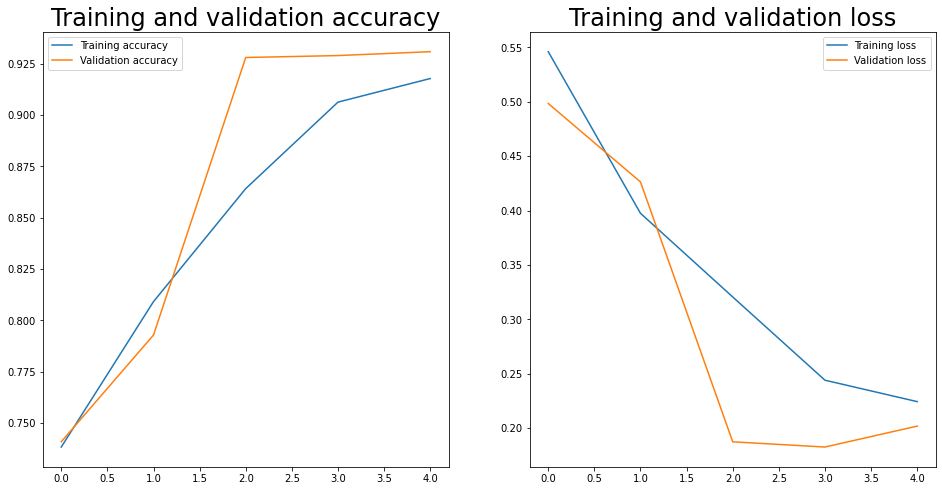

In [14]:
# Grab model results from history dict for plotting
nt_acc = nt_history.history['binary_accuracy']
nt_val_acc = nt_history.history['val_binary_accuracy']
nt_loss = nt_history.history['loss']
nt_val_loss = nt_history.history['val_loss']
nt_epochs = range(len(nt_acc))

# Plot train and val accuracy for each epoch
nt_fig,nt_ax = plt.subplots(1,2,figsize=(16,8))
nt_ax[0].plot(nt_epochs, nt_acc, label='Training accuracy');
nt_ax[0].plot(nt_epochs, nt_val_acc, label='Validation accuracy');
nt_ax[0].set_title('Training and validation accuracy',fontsize=24);
nt_ax[0].legend();

# Plot train and val loss for each epoch
nt_ax[1].plot(nt_epochs, nt_loss, label='Training loss');
nt_ax[1].plot(nt_epochs, nt_val_loss, label='Validation loss');
nt_ax[1].set_title('Training and validation loss',fontsize=24);
nt_ax[1].legend();

In [15]:
# Evaluate the model on training set
nt_train_results = nt_model.evaluate(train_ds)

131/131 [==============================] - 37s 285ms/step - loss: 0.1989 - binary_accuracy: 0.9200 - precision: 0.9531 - recall: 0.9384


In [16]:
# Evaluate the model on validation set
nt_val_res = nt_model.evaluate(val_ds)

34/34 [==============================] - 3s 92ms/step - loss: 0.1825 - binary_accuracy: 0.9290 - precision: 0.9863 - recall: 0.9170


In [17]:
# Evaluate the model on test set
nt_test_res = nt_model.evaluate(test_ds)

20/20 [==============================] - 2s 69ms/step - loss: 0.3522 - binary_accuracy: 0.8862 - precision: 0.8862 - recall: 0.9385


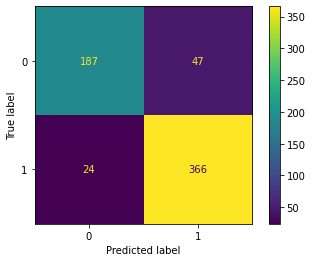

In [18]:
# Get predictions for test set and actual values
nt_test_predictions = np.round(nt_model.predict(test_ds),0)
test_actual = test_ds.labels

# Generate confusion matrix for test set
nt_c_matrix = confusion_matrix(test_actual,nt_test_predictions)
ConfusionMatrixDisplay(nt_c_matrix).plot()

<h1>Analysis of Results</h1>

<h1>Lime explanations

In [19]:
explainer = lime_image.LimeImageExplainer()

In [20]:
def extract_selected(model,true,predicted):
    selected = []

    #Loop through each image in each batch of the test dataset
    for batch in range(len(test_ds)):
        for idx,image in enumerate(test_ds[batch][0]):

            # Stop when 6 images are selected and return them
            if len(selected) >= 6:
                return(selected)

            # Select image if true and predicted classes match what was specified    
            else:
                if np.round(model.predict(np.expand_dims(image,axis=0)),0) == predicted \
                    and test_ds[batch][1][idx] == true:
                    selected.append(image)

        # Stop when 6 images are selected and return them
        if len(selected) >= 6:
                return(selected)

    # Return all images if less than 6 were selected
    return(selected)

In [21]:
def lime_explain(model,selected_images,title):
    fig,ax = plt.subplots(2,3,figsize=(12,6))

    # Loop through each of up to 6 provided image
    for idx, image in enumerate(selected_images):
        active_axis = ax[idx//3][idx%3]
        active_axis.set_xticks([])
        active_axis.set_yticks([])

        # Generate explanation for prediction using Lime image explainer
        explanation = explainer.explain_instance(
            image, model.predict, top_labels=1, hide_color=0, num_samples=1000)

        # Generate image mask for explanation    
        temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],\
             positive_only=False, num_features=5, hide_rest=False)

        # Show the image and explanation
        active_axis.imshow(mark_boundaries(temp, mask))
    fig.set_facecolor('#FFFFFF')
    fig.suptitle(title,fontsize=32);
    return(fig)

<h1>True Positives

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

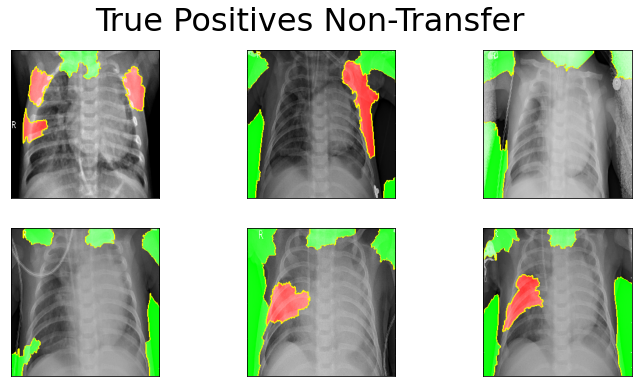

In [22]:
# Extract true positives from test set and explain with lime
nt_tp = extract_selected(nt_model,1,1)
nt_tp_expl = lime_explain(nt_model,nt_tp,"True Positives Non-Transfer")

<h1>True Negatives

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

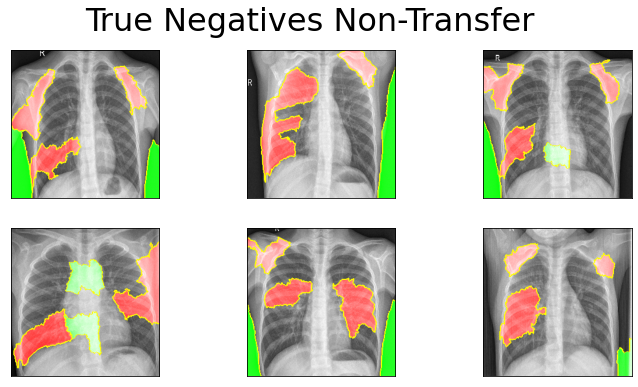

In [23]:
# Extract true negatives from test set and explain with lime
nt_tn = extract_selected(nt_model,0,0)
nt_tn_expl = lime_explain(nt_model,nt_tn,"True Negatives Non-Transfer")

<h1>Fasle Positives

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

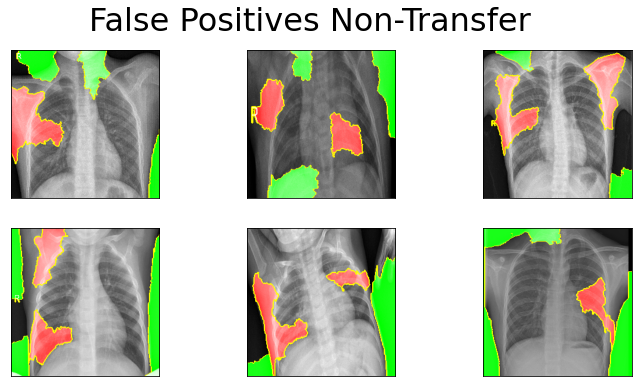

In [24]:
# Extract false positives from test set and explain with lime
nt_fp = extract_selected(nt_model,0,1)
nt_fp_expl = lime_explain(nt_model,nt_fp,"False Positives Non-Transfer")

<h1>False Negatives

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

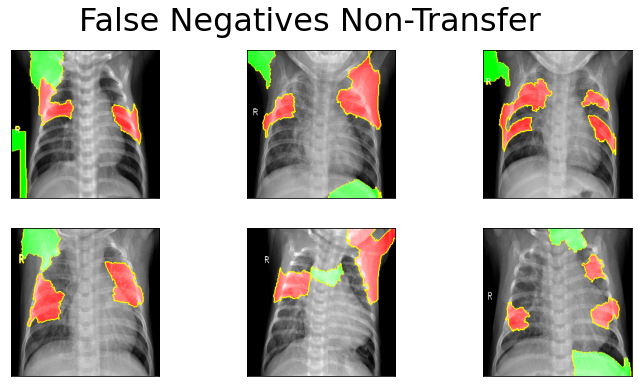

In [25]:
# Extract false negatives from test set and explain with lime
nt_fn = extract_selected(nt_model,1,0)
nt_fn_expl = lime_explain(nt_model,nt_fn,"False Negatives Non-Transfer")

<h1>Intermediate Activations

In [26]:
# Print overview of the model
nt_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      128       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      1056      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      2112      
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 64)      4160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                    

In [27]:
# Collect outputs for the first 12 layers of model
nt_layer_outputs = [layer.output for layer in nt_model.layers[:12]]

activation_model = models.Model(
    inputs = nt_model.input,
    outputs = nt_layer_outputs
)

# Predict the first image in test dataset and save intermediate activations
nt_activations = activation_model.predict(np.expand_dims(test_ds[0][0][0],axis=0))

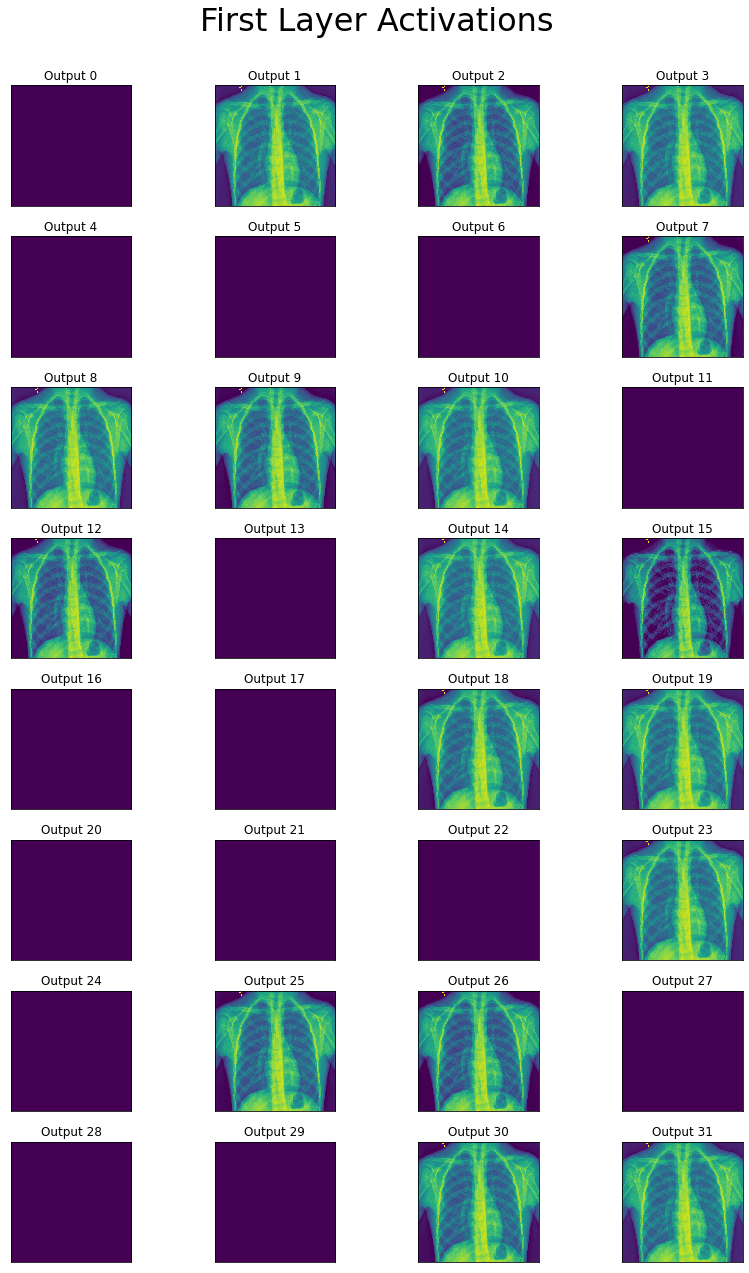

In [28]:
nt_l0_fig, nt_l0_ax = plt.subplots(8, 4, figsize=(12,18))

# Loop through each node in the first layer size 32
for idx in range(32):
    active_axis = nt_l0_ax[idx//4, idx%4]

    # Extract and show node's activation
    first_layer_activation = nt_activations[0]
    active_axis.matshow(first_layer_activation[0, :, :, idx])
    active_axis.set_xticks([])
    active_axis.set_yticks([])
    active_axis.set_title('Output ' + str(idx))
nt_l0_fig.set_facecolor('#FFFFFF')
nt_l0_fig.suptitle('First Layer Activations\n',fontsize=32);
nt_l0_fig.tight_layout()

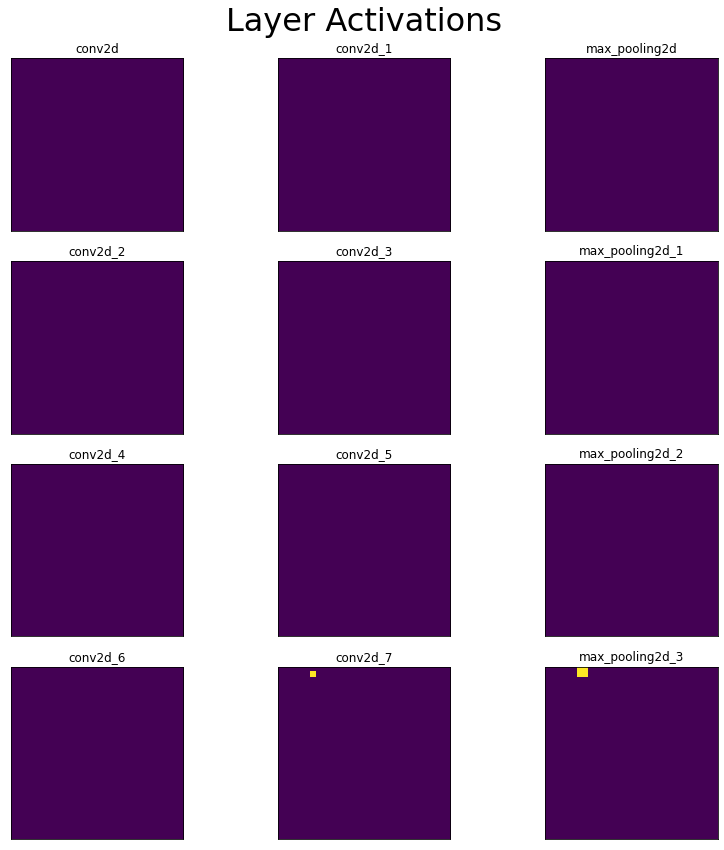

In [29]:
nt_act_fig,nt_act_ax = plt.subplots(4,3,figsize=(12,12))

# Get name for each of the first 12 layers
nt_layer_names = []
for layer in nt_model.layers[:12]:
    nt_layer_names.append(layer.name)

# Loop through each of the first 12 layers
for idx in range(12):
    active_axis = nt_act_ax[idx//3][idx%3]

    # Show the activation for the first node in that layer
    cur_layer = nt_activations[idx]
    active_axis.matshow(cur_layer[0,:,:,0])
    active_axis.set_title(nt_layer_names[idx])
    active_axis.set_xticks([])
    active_axis.set_yticks([])
nt_act_fig.set_facecolor('#FFFFFF')
nt_act_fig.suptitle('Layer Activations',fontsize=32);
nt_act_fig.tight_layout()

<h1>Best Model (Transfer Learning with VGG16)

In [30]:
# Download and load VGG16 pre-trained model
vgg_base = applications.VGG16(
    weights='imagenet',
    input_shape=(256, 256, 3),
    include_top=False
)

# Don't allow vgg16 weights to be changed
vgg_base.trainable = False

58900480/58889256 [==============================] - 1s 0us/step


In [31]:
tx_model = models.Sequential()

# Add vgg16 base to transfer model
tx_model.add(vgg_base)     

# Densely connected block without dropout
tx_model.add(layers.Flatten())
tx_model.add(layers.Dense(512, activation='relu'))
tx_model.add(layers.Dense(256, activation='relu'))
tx_model.add(layers.Dense(128, activation='relu'))
tx_model.add(layers.Dense(64, activation='relu'))
tx_model.add(layers.Dense(1, activation='sigmoid'))

for layer in tx_model.layers:
    print(layer.name, layer.trainable)

vgg16 False
flatten_1 True
dense_7 True
dense_8 True
dense_9 True
dense_10 True
dense_11 True


In [32]:
# Checkpoint the model after each epoch
tx_checkpoint = callbacks.ModelCheckpoint(
    monitor='val_loss',
    filepath='save_data/tx_model.hdf5',
    save_best_only=True,
    verbose=0
)

tx_callbacks = [tx_checkpoint]

# Metrics are Accuracy, Precision, and Recall
use_metrics = [metrics.BinaryAccuracy(),\
                metrics.Precision(),\
                metrics.Recall()]

In [33]:
# Make scheduler to add learning rate decay to the model
scheduler = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_rate=0.96,
    decay_steps=2500
)

In [34]:
# Compile the model with the Adam optimizer and decaying learning rate
tx_model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(learning_rate=scheduler),
    metrics=[use_metrics]
)

# Print overview of the model
print(tx_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_7 (Dense)             (None, 512)               16777728  
                                                                 
 dense_8 (Dense)             (None, 256)               131328    
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 1)                

In [35]:
# Fit the model and save results to history
with tf.device('/GPU:0'):
    tx_history = tx_model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=5,
        callbacks=tx_callbacks
    )

# Load the best model based on validation loss
tx_model = models.load_model('save_data/tx_model.hdf5')

Epoch 1/5
131/131 [==============================] - 62s 327ms/step - loss: 0.3261 - binary_accuracy: 0.8663 - precision_1: 0.9105 - recall_1: 0.9094 - val_loss: 0.1424 - val_binary_accuracy: 0.9395 - val_precision_1: 0.9712 - val_recall_1: 0.9464
Epoch 2/5
131/131 [==============================] - 41s 313ms/step - loss: 0.1934 - binary_accuracy: 0.9260 - precision_1: 0.9491 - recall_1: 0.9513 - val_loss: 0.1641 - val_binary_accuracy: 0.9347 - val_precision_1: 0.9945 - val_recall_1: 0.9170
Epoch 3/5
131/131 [==============================] - 44s 335ms/step - loss: 0.1504 - binary_accuracy: 0.9466 - precision_1: 0.9660 - recall_1: 0.9619 - val_loss: 0.3918 - val_binary_accuracy: 0.8089 - val_precision_1: 1.0000 - val_recall_1: 0.7420
Epoch 4/5
131/131 [==============================] - 41s 312ms/step - loss: 0.1327 - binary_accuracy: 0.9492 - precision_1: 0.9682 - recall_1: 0.9632 - val_loss: 0.3558 - val_binary_accuracy: 0.8657 - val_precision_1: 1.0000 - val_recall_1: 0.8186
Epoch 5/

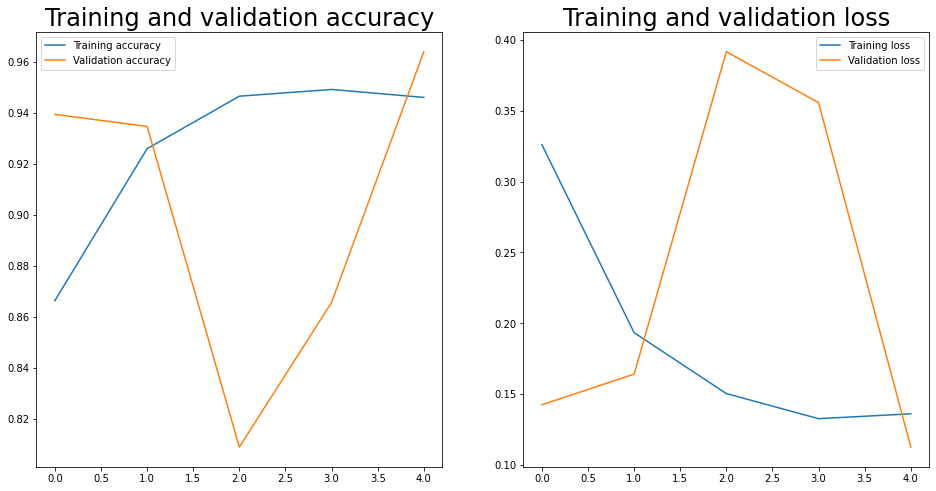

In [36]:
# Grab model results from history dict for plotting
tx_acc = tx_history.history['binary_accuracy']
tx_val_acc = tx_history.history['val_binary_accuracy']
tx_loss = tx_history.history['loss']
tx_val_loss = tx_history.history['val_loss']
tx_epochs = range(len(tx_acc))

# Plot train and val accuracy for each epoch
tx_fig,tx_ax = plt.subplots(1,2,figsize=(16,8))
tx_ax[0].plot(tx_epochs, tx_acc, label='Training accuracy');
tx_ax[0].plot(tx_epochs, tx_val_acc, label='Validation accuracy');
tx_ax[0].set_title('Training and validation accuracy',fontsize=24);
tx_ax[0].legend();

# Plot train and val loss for each epoch
tx_ax[1].plot(tx_epochs, tx_loss, label='Training loss');
tx_ax[1].plot(tx_epochs, tx_val_loss, label='Validation loss');
tx_ax[1].set_title('Training and validation loss',fontsize=24);
tx_ax[1].legend();

In [37]:
# Evaluate the model on training set
tx_train_res = tx_model.evaluate(train_ds)

131/131 [==============================] - 37s 284ms/step - loss: 0.1752 - binary_accuracy: 0.9150 - precision_1: 0.9021 - recall_1: 0.9932


In [38]:
# Evaludate the model on validation set
tx_val_res = tx_model.evaluate(val_ds)

34/34 [==============================] - 4s 98ms/step - loss: 0.1126 - binary_accuracy: 0.9640 - precision_1: 0.9895 - recall_1: 0.9617


In [39]:
# Evaluate the model on test set
tx_test_res = tx_model.evaluate(test_ds)

20/20 [==============================] - 2s 99ms/step - loss: 0.3245 - binary_accuracy: 0.8750 - precision_1: 0.8362 - recall_1: 0.9949


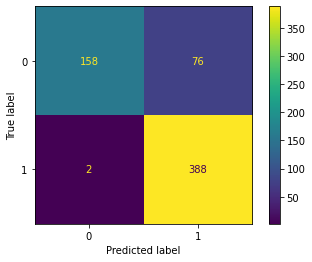

In [40]:
# Get predictions for test set and actual values
tx_test_predictions = np.round(tx_model.predict(test_ds),0)
test_actual = test_ds.labels

# Generate confusion matrix for test set
tx_c_matrix = confusion_matrix(test_actual,tx_test_predictions)
ConfusionMatrixDisplay(tx_c_matrix).plot()

<h1>Analysis of Results</h1>

In [41]:
explainer = lime_image.LimeImageExplainer()

<h1>True Positives

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

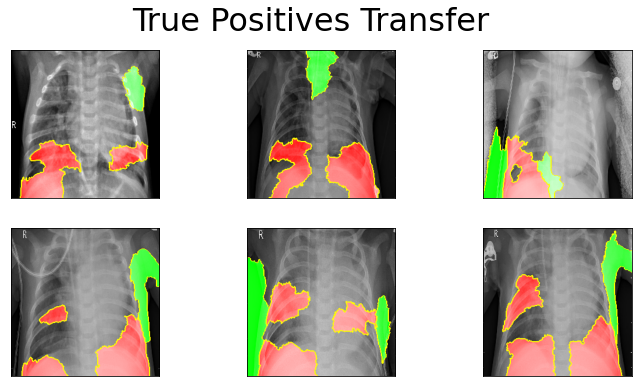

In [42]:
# Extract true positives from test set and explain with lime
tx_tp = extract_selected(tx_model,1,1)
tx_tp_expl = lime_explain(tx_model,tx_tp,"True Positives Transfer")

<h1>True Negatives

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

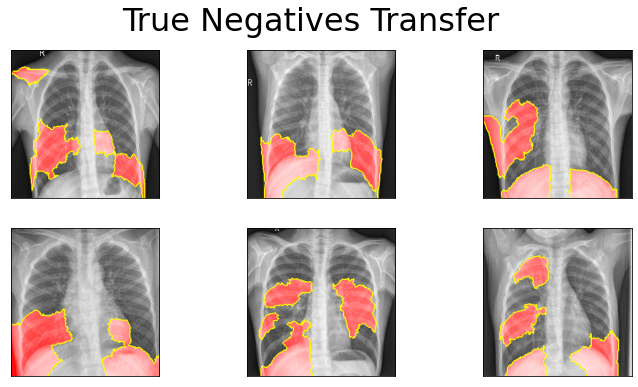

In [43]:
# Extract true negatives from test set and explain with lime
tx_tn = extract_selected(tx_model,0,0)
tx_tn_expl = lime_explain(tx_model,tx_tn,"True Negatives Transfer")

<h1>Fasle Positives

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

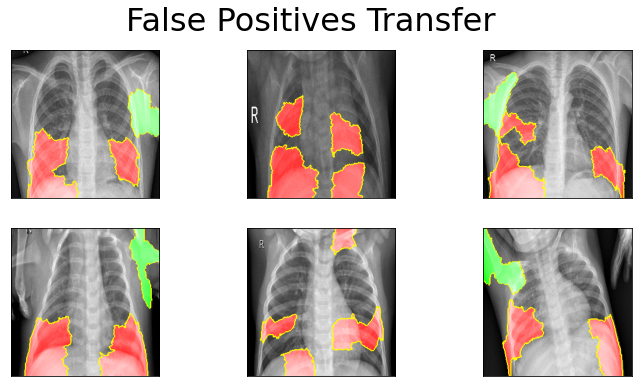

In [44]:
# Extract false positives from test set and explain with lime
tx_fp = extract_selected(tx_model,0,1)
tx_fp_expl = lime_explain(tx_model,tx_fp,"False Positives Transfer")

<h1>False Negatives

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

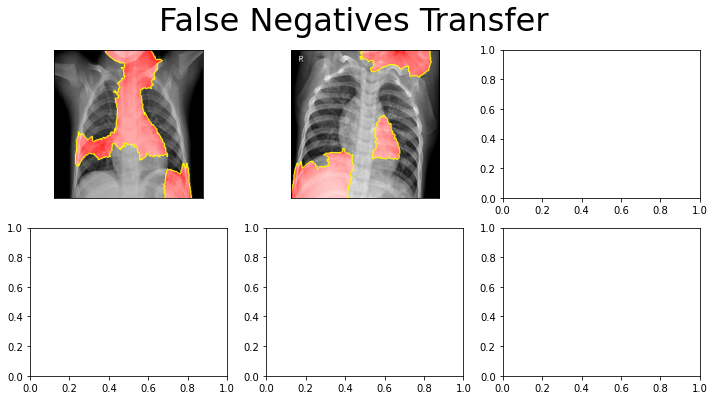

In [45]:
# Extract false negatives from test set and explain with lime
tx_fn = extract_selected(tx_model,1,0)
tx_fn_expl = lime_explain(tx_model,tx_fn,"False Negatives Transfer")

<h1>Intermediate Activations

In [46]:
# Print overview of the model
tx_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_7 (Dense)             (None, 512)               16777728  
                                                                 
 dense_8 (Dense)             (None, 256)               131328    
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 1)                

In [47]:
# Print overview of the model's vgg16 layers
tx_model.layers[0].summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [48]:
# Collect outputs for the vgg16 layers
tx_layer_outputs = [layer.output for layer in tx_model.layers[0].layers]

tx_activation_model = models.Model(
    inputs = tx_model.layers[0].input,
    outputs = tx_layer_outputs
)

# Predict the first image in test dataset and save intermediate activations
activations = tx_activation_model.predict(np.expand_dims(test_ds[0][0][0],axis=0))

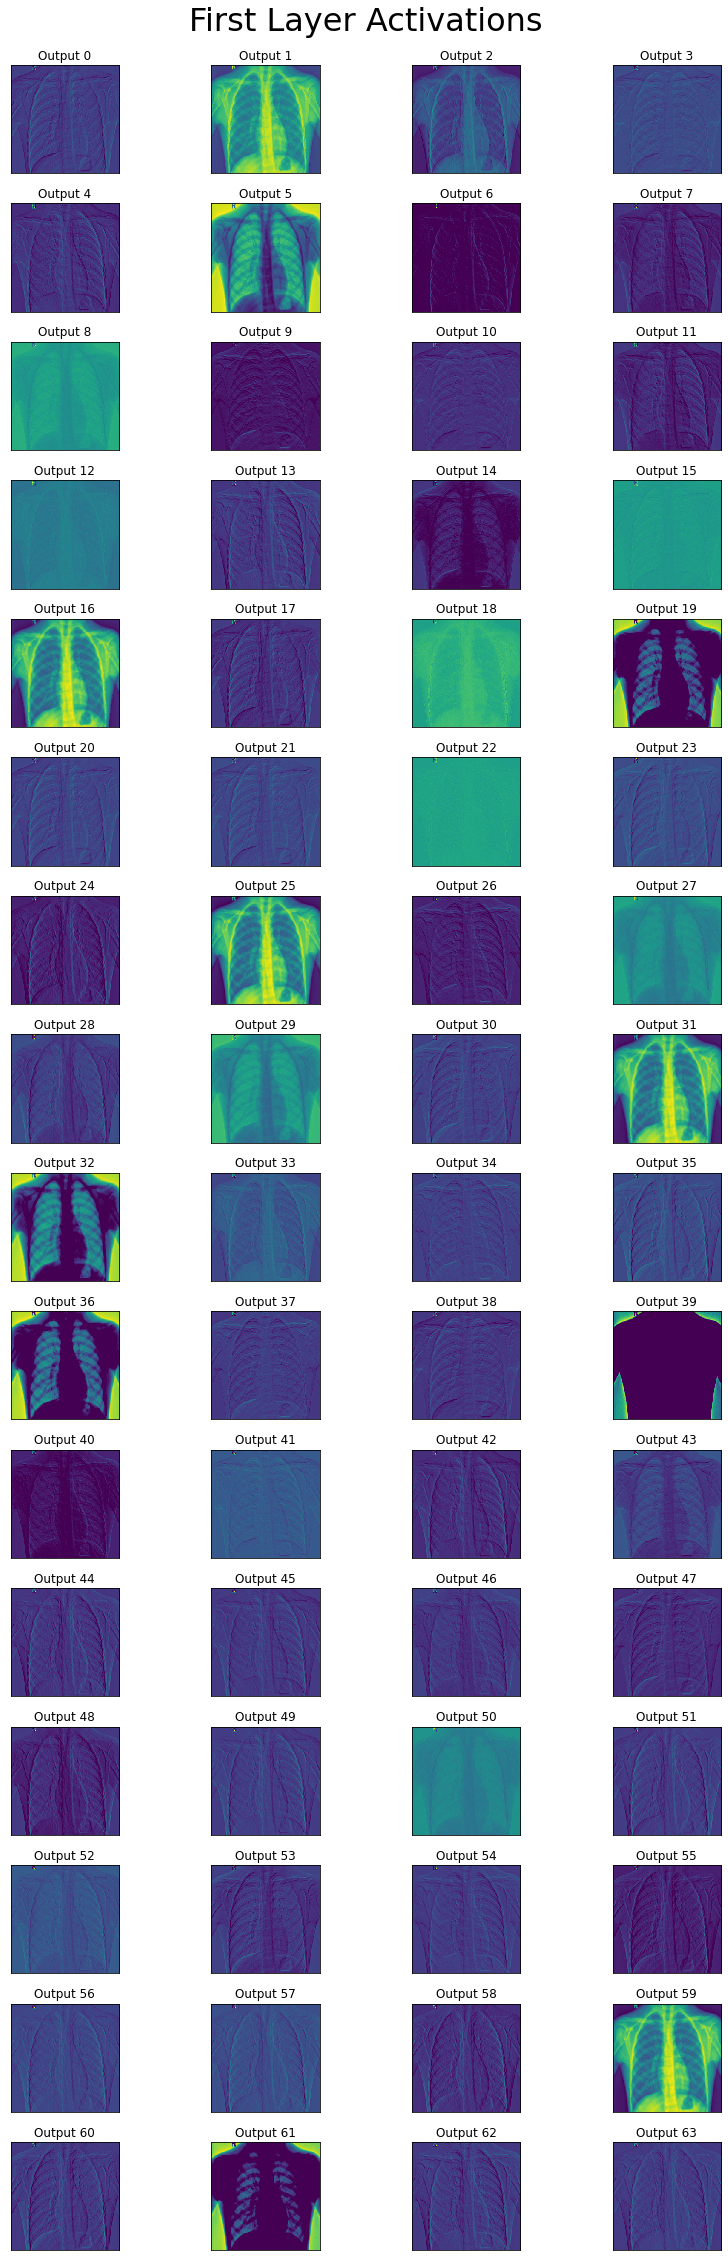

In [49]:
tx_l0_fig, tx_l0_ax = plt.subplots(16, 4, figsize=(12,32))

# Loop through each node in the first layer size 64
for idx in range(64):
    active_axis = tx_l0_ax[idx//4, idx%4]

    # EXtract and show node's activation
    first_layer_activation = activations[1]
    active_axis.matshow(first_layer_activation[0 , :, :, idx])
    active_axis.set_xticks([])
    active_axis.set_yticks([])
    active_axis.set_title('Output ' + str(idx))
tx_l0_fig.set_facecolor('#FFFFFF')
tx_l0_fig.suptitle('First Layer Activations\n',fontsize=32);
tx_l0_fig.tight_layout()

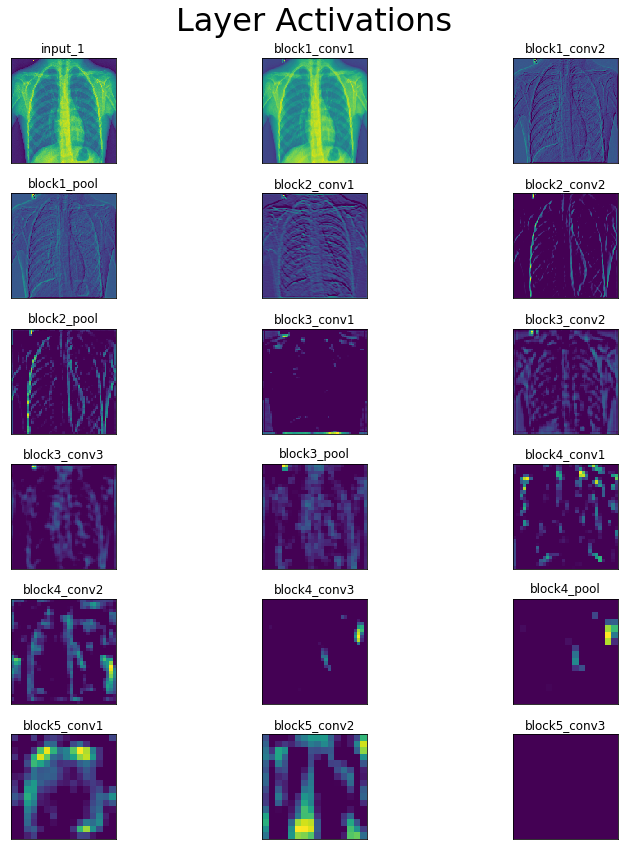

In [50]:
tx_act_fig,tx_act_ax = plt.subplots(6,3,figsize=(12,12))

# Get name for each of the vgg16 layers
tx_layer_names = []
for layer in tx_model.layers[0].layers:
    tx_layer_names.append(layer.name)

# Loop through each of the vgg16 layers
for idx in range(18):
    active_axis = tx_act_ax[idx//3][idx%3]

    # Show the activation for the first node in that layer
    cur_layer = activations[idx]
    active_axis.matshow(cur_layer[0,:,:,1])
    active_axis.set_title(tx_layer_names[idx])
    active_axis.set_xticks([])
    active_axis.set_yticks([])
tx_act_fig.set_facecolor('#FFFFFF')
tx_act_fig.suptitle('Layer Activations',fontsize=32);
tx_act_fig.tight_layout()